注意力打分函数

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

1. 遮蔽mask-softmax操作\
   就是 只对有用的数据长度算出softmax

In [2]:
# X:3D张量，valid_lens:1D或2D张量
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上屏蔽元素来执行 softmax 操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else :
        shape = X.shape
        if valid_lens.dim() == 1:
            # shape[1] 及就是 batch-size
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

torch.repeat_interleave(input, repeats, dim=None) → Tensor

In [3]:
# 1）input (类型：torch.Tensor)：输入张量
# 2）repeats（类型：int或torch.Tensor）：每个元素的重复次数
# 3）dim（类型：int）需要重复的维度。
#    默认情况下dim=None，表示将把给定的输入张量展平（flatten）为向量，然后将每个元素重复repeats次，并返回重复后的张量。

a = torch.randn(3)
a,torch.repeat_interleave(a,2)

(tensor([ 0.1117, -0.9429, -1.0103]),
 tensor([ 0.1117,  0.1117, -0.9429, -0.9429, -1.0103, -1.0103]))

X维度如何变换

In [4]:
X = torch.rand(2, 2, 4)
# 最后一个维度最大长度maxlen不变,将之前的batch—size和num-step压缩在一起
X,X.reshape(-1, X.shape[-1])

(tensor([[[0.8879, 0.4221, 0.2569, 0.6409],
          [0.1001, 0.3767, 0.4894, 0.2545]],
 
         [[0.8074, 0.8528, 0.2059, 0.4432],
          [0.2200, 0.2150, 0.9373, 0.1902]]]),
 tensor([[0.8879, 0.4221, 0.2569, 0.6409],
         [0.1001, 0.3767, 0.4894, 0.2545],
         [0.8074, 0.8528, 0.2059, 0.4432],
         [0.2200, 0.2150, 0.9373, 0.1902]]))

masked_softmax工作方式

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3997, 0.6003, 0.0000, 0.0000],
         [0.5760, 0.4240, 0.0000, 0.0000]],

        [[0.3302, 0.2397, 0.4300, 0.0000],
         [0.2865, 0.3563, 0.3572, 0.0000]]])

In [6]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2313, 0.3623, 0.4064, 0.0000]],

        [[0.5933, 0.4067, 0.0000, 0.0000],
         [0.2979, 0.2395, 0.2525, 0.2100]]])

2. 加性注意力(主要用于查询query和键key是不同长度的矢量时)

In [7]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs) :
        super(AdditiveAttention, self).__init__(**kwargs)

        # Wq Wk Wv 就是可学习参数
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_v = nn.Linear(num_hiddens, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        # valid_lens 主要作用就是来限制queries中的句子长度不够需要padding的部分
        queries = self.W_q(queries)
        keys    = self.W_k(keys)

        # 维度拓展前
        # queries的形状：(batch_size，num_querys，num_hidden)
        #   key  的形状：(batch_size，num_keys，  num_hidden)

        # 使用breadcast广播方式进行求和
        # 分别在queries的第二维和keys的第一维进行生维
        queries = queries.unsqueeze(2)
        keys =  keys.unsqueeze(1)

        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        #   key  的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        
        # 此时便可以每一位相加
        # [batch_size, num_query, num_key, num_hidden]
        features = queries + keys 
        features = torch.tanh(features)
        # [batch_size, num_query, num_key, 1] 将最后一维脱离降低维度
        scores = self.W_v(features).squeeze(-1)

        # 掩码softmax运算
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


实例化Attention

In [8]:
queries = torch.normal(0, 1, (2, 1, 20))
keys    = torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

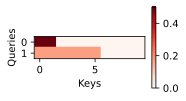

In [25]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# 这里可以看到 前面的valid_len=2所以主要的注意力权重就在前2项、
# 但是这里取得每个key其实是相同的，所以看到的注意力权重均匀分布

缩放点积注意力(主要适用于query和key有相同的长度d)

In [36]:
class DotProductAttention(nn.Module):

    def __init__(self, dropout, **kwargs) -> None:
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weight = masked_softmax(scores, valid_lens)

        return torch.bmm(self.dropout(self.attention_weight), values)


In [37]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

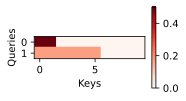

In [39]:
d2l.show_heatmaps(attention.attention_weight.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')